In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import pickle

In [4]:
path = r'C:\Users\marcu\Documents\Quant\Programming\Data\russell_300_returns.pickle'

with open(path, 'rb') as reader:
    returns = pickle.load(reader)

returns = returns.iloc[:, 0].dropna()

<AxesSubplot:>

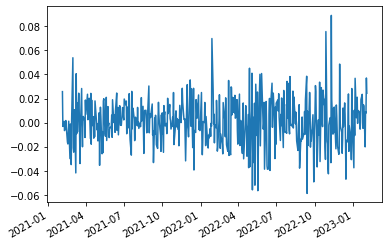

In [3]:
returns = returns.tail(252*2)
returns.plot()

In [158]:
returns.describe()

count   3646.0000
mean       0.0011
std        0.0197
min       -0.1792
25%       -0.0079
50%        0.0010
75%        0.0111
max        0.1390
Name: AAPL, dtype: float64

In [78]:
def bootstrap_summary_data(synthetic_data: pd.DataFrame, empirical_data: pd.Series):

        # Change desired formatting
        pd.options.display.float_format = '{:.4f}'.format

        # Declare temp hash tables to store relevant statistics
        bootstrap_summary_data = {}
        empirical_summary_data = {}
               
        # Mean
        mean = np.mean(np.mean(synthetic_data))
        bootstrap_summary_data['Mean'] = mean
        empirical_summary_data['Mean'] = np.mean(empirical_data)

        # Standard Deviation
        mean_std = np.mean(np.std(synthetic_data))
        bootstrap_summary_data['STD'] = mean_std
        empirical_summary_data['STD'] = np.std(empirical_data)

        # Mean Skew
        mean_skew = np.mean(stats.skew(synthetic_data))
        bootstrap_summary_data['Skew'] = mean_skew
        empirical_summary_data['Skew'] = stats.skew(empirical_data)

        # Mean Kurtosis
        mean_kurtosis = np.mean(stats.kurtosis(synthetic_data, fisher=False))
        bootstrap_summary_data['Kurtosis'] = mean_kurtosis
        empirical_summary_data['Kurtosis'] = stats.kurtosis(empirical_data, fisher=False)

        # Mean 5'th Moment (Asymmetry of Tails)
        mean_5th_moment = np.mean(stats.moment(synthetic_data, moment=5))
        bootstrap_summary_data['5th Moment'] = mean_5th_moment
        empirical_summary_data['5th Moment'] = stats.moment(empirical_data, moment=5)

        # Standard Deviation of Mean
        std_mean = np.std(np.mean(synthetic_data))
        bootstrap_summary_data['STD of Mean'] = std_mean

        # Standard Deviation of Median
        std_median = np.std((synthetic_data).median())
        bootstrap_summary_data['STD of Median'] = std_median

        # Mean Squared Error
        mse = ((synthetic_data.mean() - empirical_data.mean())**2).mean()
        bootstrap_summary_data['MSE'] = mse

        # R^2
        r_2 = np.sum((synthetic_data.mean() - empirical_data.mean())**2) / np.sum((empirical_data - empirical_data.mean())**2)
        bootstrap_summary_data['R^2'] = r_2

        # P-Value
        synth_cum_rets = (np.exp(np.log(synthetic_data+1).cumsum().iloc[:, 0:1000])-1).iloc[-1,:] # use log returns for faster computations
        empirical_cum_rets = ((1+empirical_data).cumprod()-1).iloc[-1]
        p_value = len(synth_cum_rets[synth_cum_rets>empirical_cum_rets]) / len(synth_cum_rets)
        empirical_summary_data['P-Value'] = p_value


        # Summarize Data
        bootstrap_summary_data = pd.Series(bootstrap_summary_data, name='Bootstrap Summary Statistics')
        empirical_summary_data = pd.Series(empirical_summary_data, name='Historical Summary Statistics')

        summary_data = pd.concat([bootstrap_summary_data, empirical_summary_data], axis=1)
        
        return summary_data

In [140]:
def wild_bootstrap(returns: pd.Series, n_samples=10000, normal=False):
    """
    Perform Wild Bootstrap on a 1D array of financial time series data.

    Args:
    returns (numpy.ndarray or pd.Series): A 1D array of data.
    n_samples (int): The number of resamples to generate.
    normal (bool): Determines the probability distribution of the noise element (Gaussian or Laplace).

    For more information on Laplace Distribution: https://www.statisticshowto.com/laplace-distribution-double-exponential/
    For more information on Wild Bootstrap Method: https://stats.stackexchange.com/questions/408651/intuitively-how-does-the-wild-bootstrap-work
    
    Returns:
    pd.DataFrame: An matrix of bootstrapped returns.
    """

    # Initialize length per sample
    n = len(returns)

    # Initialize bootstrap samples matrix
    wild_bootsrapped_samples = np.empty((n_samples, n))

    # Generate n_samples of length n
    for i in range(0, n_samples):
        
        # ------------------------------------------- Generate Noise -------------------------------------------
        if normal:
            # Generate random perturbations from a standardized distribution (e.g., Standard Normal)
            perturbations = np.random.standard_normal(n)

        else: 
            laplace_mu = 0
            laplace_beta =  np.sqrt(np.var(returns)/2)
            # perturbations = np.random.laplace(loc=laplace_mu, scale=laplace_beta, size=n)
            perturbations = np.random.laplace(loc=laplace_mu, scale=1, size=n)

        # ------------------------------------------- Scale Noise -------------------------------------------
        # Randomly sample returns (shuffle) from empirical distribution and scale by Gaussian perturbations
        
        # Sample without replacement
        # wild_noise = np.random.choice(returns, size=n, replace=False) * perturbations 

        # Scale noise with original data
        # wild_noise = returns * perturbations

        # Method to bootstrap the noise element... seems to make the returns more closely skewed 
        # to empirical distribution which may be a better approximation of the posterior:
        # wild_noise = np.random.choice(returns, size=n, replace=True) * perturbations

        # Generate two bootstrapped samples and choose the higher of the two to generate negative skew:
        # This generates too negatively skewed returns with a negative mean... not a good approximation of posterior
        wild_noise = np.empty(shape=(returns.shape[0]))
        for j in range(0, n):
            wild_noise[j] = np.max(np.random.choice(returns, size=2, replace=True))
        
        wild_noise = wild_noise * perturbations
        
        # ------------------------------------------- Generate Samples -------------------------------------------
        # Add the wild noise to the original data
        wild_bootsrapped_samples[i] = (returns + wild_noise).values        

        # Add the wild noise to the shuffled data
        # wild_bootsrapped_samples[i] = np.random.choice(returns, size=n, replace=False) + wild_noise
        
        
        # Use if you want to center returns around mean (should be used in conjunction with bootstrapped noise)
        # wild_bootsrapped_samples[i] = (wild_noise + np.mean(returns)) 
        
    return pd.DataFrame(wild_bootsrapped_samples, columns=returns.index).T

In [111]:
bootstrapped_sample_normal.shape

(3646, 10000)

In [144]:
bootstrapped_sample_normal_SKEWED = wild_bootstrap(returns, n_samples=10000, normal=True)
bootstrap_summary_data(bootstrapped_sample_normal_SKEWED, returns)

# Gaussian noise

Add the wild noise to the originally ordered data + scale noise by unshuffled returns  

In [401]:
bootstrapped_sample_normal = wild_bootstrap(returns, n_samples=50000, normal=False)
bootstrap_summary_data(bootstrapped_sample_normal, returns)

,Bootstrap Summary Statistics,Historical Summary Statistics
Mean,0.0011,0.0011
STD,0.0341,0.0197
Skew,-0.0044,-0.1171
Kurtosis,35.4228,9.7443
5th Moment,-0.0000,-0.0000
STD of Mean,0.0005,NaN
STD of Median,0.0001,NaN
MSE,0.0000,NaN
R^2,0.0075,NaN


28.70374366640139 0.136


<AxesSubplot:>

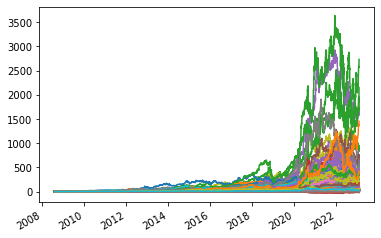

In [402]:
cum_rets_normal = (1+bootstrapped_sample_normal.iloc[:, 0:3000]).cumprod()-1
mean_portfolo_value = cum_rets_normal.iloc[-1, :].mean()
pct_neg = len(cum_rets_normal.iloc[-1, :][cum_rets_normal.iloc[-1, :]<0]) / len(cum_rets_normal.iloc[-1, :])
print(mean_portfolo_value, pct_neg)
cum_rets_normal.plot(legend=None)

Add the wild noise to the originally ordered data + scale noise by shuffled non-replaced returns

In [405]:
bootstrapped_sample_normal = wild_bootstrap(returns, n_samples=50000, normal=False)
bootstrap_summary_data(bootstrapped_sample_normal, returns)

,Bootstrap Summary Statistics,Historical Summary Statistics
Mean,0.0011,0.0011
STD,0.0341,0.0197
Skew,-0.0185,-0.1171
Kurtosis,25.2364,9.7443
5th Moment,-0.0000,-0.0000
STD of Mean,0.0005,NaN
STD of Median,0.0003,NaN
MSE,0.0000,NaN
R^2,0.0076,NaN


30.341043628817932 0.135


<AxesSubplot:>

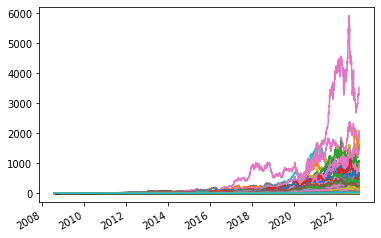

In [406]:
cum_rets_normal = (1+bootstrapped_sample_normal.iloc[:, 0:3000]).cumprod()-1
mean_portfolo_value = cum_rets_normal.iloc[-1, :].mean()
pct_neg = len(cum_rets_normal.iloc[-1, :][cum_rets_normal.iloc[-1, :]<0]) / len(cum_rets_normal.iloc[-1, :])
print(mean_portfolo_value, pct_neg)
cum_rets_normal.plot(legend=None)

Add the wild noise to the original data + scale noise by shuffled replaced (bootstrapped) returns

In [408]:
bootstrapped_sample_normal = wild_bootstrap(returns, n_samples=50000, normal=False)
bootstrap_summary_data(bootstrapped_sample_normal, returns)

,Bootstrap Summary Statistics,Historical Summary Statistics
Mean,0.0011,0.0011
STD,0.0341,0.0197
Skew,-0.0303,-0.1171
Kurtosis,25.0152,9.7443
5th Moment,-0.0000,-0.0000
STD of Mean,0.0005,NaN
STD of Median,0.0003,NaN
MSE,0.0000,NaN
R^2,0.0075,NaN


27.516957923424247 0.13933333333333334


<AxesSubplot:>

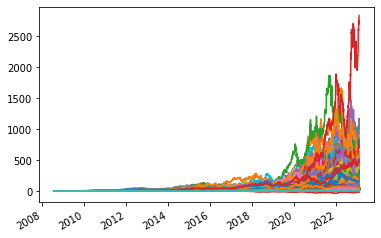

In [409]:
cum_rets_normal = (1+bootstrapped_sample_normal.iloc[:, 0:3000]).cumprod()-1
mean_portfolo_value = cum_rets_normal.iloc[-1, :].mean()
pct_neg = len(cum_rets_normal.iloc[-1, :][cum_rets_normal.iloc[-1, :]<0]) / len(cum_rets_normal.iloc[-1, :])
print(mean_portfolo_value, pct_neg)
cum_rets_normal.plot(legend=None)

Add the wild noise to shuffled data + scale noise by shuffled replaced (bootstrapped) returns

In [413]:
bootstrapped_sample_normal = wild_bootstrap(returns, n_samples=50000, normal=False)
bootstrap_summary_data(bootstrapped_sample_normal, returns)

,Bootstrap Summary Statistics,Historical Summary Statistics
Mean,0.0011,0.0011
STD,0.0341,0.0197
Skew,-0.0236,-0.1171
Kurtosis,25.1414,9.7443
5th Moment,-0.0000,-0.0000
STD of Mean,0.0005,NaN
STD of Median,0.0003,NaN
MSE,0.0000,NaN
R^2,0.0076,NaN


26.583310339173856 0.13066666666666665


<AxesSubplot:>

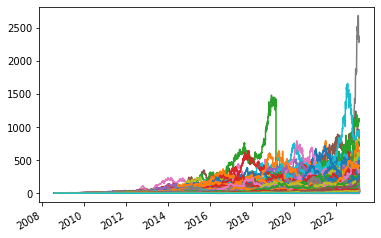

In [414]:
cum_rets_normal = (1+bootstrapped_sample_normal.iloc[:, 0:3000]).cumprod()-1
mean_portfolo_value = cum_rets_normal.iloc[-1, :].mean()
pct_neg = len(cum_rets_normal.iloc[-1, :][cum_rets_normal.iloc[-1, :]<0]) / len(cum_rets_normal.iloc[-1, :])
print(mean_portfolo_value, pct_neg)
cum_rets_normal.plot(legend=None)

Add the wild noise to mean returns + scale noise by shuffled replaced (bootstrapped) returns

In [416]:
bootstrapped_sample_normal = wild_bootstrap(returns, n_samples=50000, normal=False)
bootstrap_summary_data(bootstrapped_sample_normal, returns)

,Bootstrap Summary Statistics,Historical Summary Statistics
Mean,0.0011,0.0011
STD,0.0278,0.0197
Skew,-0.0018,-0.1171
Kurtosis,49.3865,9.7443
5th Moment,-0.0000,-0.0000
STD of Mean,0.0005,NaN
STD of Median,0.0000,NaN
MSE,0.0000,NaN
R^2,0.0076,NaN


58.71773845835013 0.057


<AxesSubplot:>

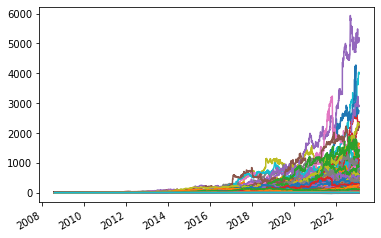

In [417]:
cum_rets_normal = (1+bootstrapped_sample_normal.iloc[:, 0:3000]).cumprod()-1
mean_portfolo_value = cum_rets_normal.iloc[-1, :].mean()
pct_neg = len(cum_rets_normal.iloc[-1, :][cum_rets_normal.iloc[-1, :]<0]) / len(cum_rets_normal.iloc[-1, :])
print(mean_portfolo_value, pct_neg)
cum_rets_normal.plot(legend=None)

FINAL METHOD: SCALE NOISE BY BOOTSTRAPPED RETURNS + ORIGINAL RETURNS DATASET

In [91]:
bootstrapped_sample_normal = wild_bootstrap(returns, n_samples=10000, normal=False)
bootstrap_summary_data(bootstrapped_sample_normal, returns)

,Bootstrap Summary Statistics,Historical Summary Statistics
Mean,0.0011,0.0011
STD,0.0341,0.0197
Skew,-0.0470,-0.1171
Kurtosis,25.3532,9.7443
5th Moment,-0.0000,-0.0000
STD of Mean,0.0005,NaN
STD of Median,0.0003,NaN
MSE,0.0000,NaN
R^2,0.0015,NaN
P-Value,NaN,0.1970


Mean Cum Return = 27.489151094636966
 Percent Cum Rets < 0 = 0.132


<AxesSubplot:>

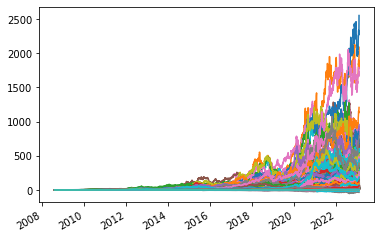

In [95]:
cum_rets_normal = (1+bootstrapped_sample_normal.iloc[:, 0:3000]).cumprod()-1
mean_portfolo_value = cum_rets_normal.iloc[-1, :].mean()
pct_neg = len(cum_rets_normal.iloc[-1, :][cum_rets_normal.iloc[-1, :]<0]) / len(cum_rets_normal.iloc[-1, :])
print(f'Mean Cum Return = {mean_portfolo_value}\n', f'Percent Cum Rets < 0 = {pct_neg}')
cum_rets_normal.plot(legend=None)

# Laplace noise

FINAL METHOD: SCALE NOISE BY BOOTSTRAPPED RETURNS + ORIGINAL RETURNS DATASET

In [96]:
bootstrapped_sample_laplace = wild_bootstrap(returns, n_samples=10000, normal=False)
bootstrap_summary_data(bootstrapped_sample_laplace, returns)

,Bootstrap Summary Statistics,Historical Summary Statistics
Mean,0.0011,0.0011
STD,0.0341,0.0197
Skew,-0.0243,-0.1171
Kurtosis,24.9380,9.7443
5th Moment,0.0000,-0.0000
STD of Mean,0.0005,NaN
STD of Median,0.0003,NaN
MSE,0.0000,NaN
R^2,0.0015,NaN
P-Value,NaN,0.2060


Mean Cum Return = 28.501402691268915
 Percent Cum Rets < 0 = 0.14233333333333334


<AxesSubplot:>

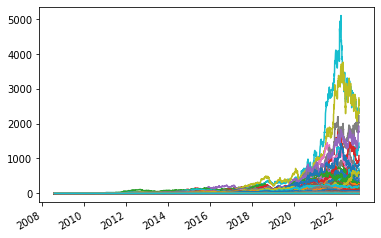

In [97]:
cum_rets_laplace = (1+bootstrapped_sample_laplace.iloc[:, 0:3000]).cumprod()-1
mean_portfolo_value = cum_rets_laplace.iloc[-1, :].mean()
pct_neg = len(cum_rets_laplace.iloc[-1, :][cum_rets_laplace.iloc[-1, :]<0]) / len(cum_rets_laplace.iloc[-1, :])
print(f'Mean Cum Return = {mean_portfolo_value}\n', f'Percent Cum Rets < 0 = {pct_neg}')
cum_rets_laplace.plot(legend=None)

# Plot Lowest Returns

-0.5406378248117281 0.3797565878866381


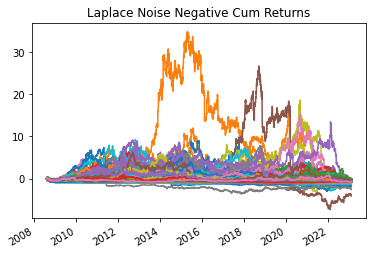

In [98]:
cols = cum_rets_laplace.iloc[-1, :][cum_rets_laplace.iloc[-1, :]<0].index
cum_rets_laplace[cols].plot(legend=None, title='Laplace Noise Negative Cum Returns')
print(cum_rets_laplace[cols].iloc[-1, :].mean(), cum_rets_laplace[cols].iloc[-1, :].std())

-0.6677774472055268 1.9928140467431288


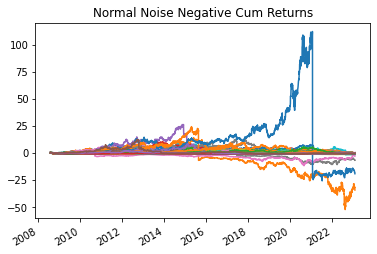

In [100]:
cols = cum_rets_normal.iloc[-1, :][cum_rets_normal.iloc[-1, :]<0].index
cum_rets_normal[cols].plot(legend=None, title='Normal Noise Negative Cum Returns')
print(cum_rets_normal[cols].iloc[-1, :].mean(), cum_rets_normal[cols].iloc[-1, :].std())

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

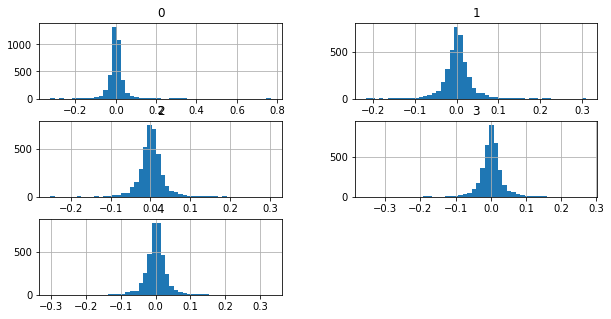

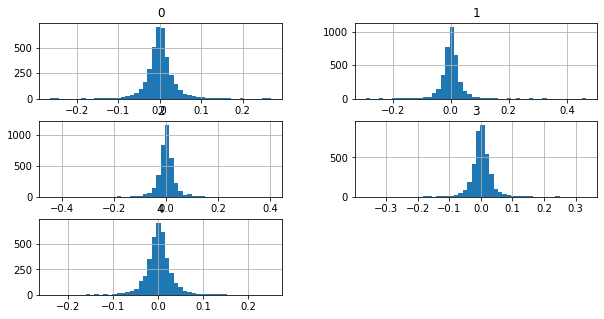

In [101]:
bootstrapped_sample_laplace.iloc[:, 0:5].hist(bins=50, figsize=(10, 5))
bootstrapped_sample_normal.iloc[:, 0:5].hist(bins=50, figsize=(10, 5))

<AxesSubplot:>

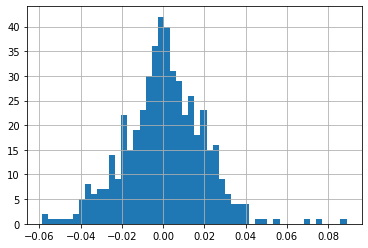

In [155]:
returns.hist(bins=50)

<AxesSubplot:>

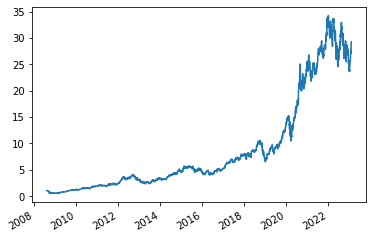

In [398]:
(1+returns).cumprod().plot()